# E3-5. Unet_Building_256_256_crop_with_hdf5
---

## Environment Setting
---

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import rasterio
from rasterio.plot import show

import math
from tqdm import tqdm

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import albumentations as A

import seaborn
seaborn.set(style='white')
seaborn.set_context('paper')

Segmentation Models: using `tf.keras` framework.


In [2]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')

            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")

init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [43]:
FILE_PATH = './data/LV1_PNG_DATASET.h5'
BASE_TARIN_DIR = "/B/train"
TRAIN_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/img'
TRAIN_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/label'
TRAIN_SPLIT_DIR = f'{Path(BASE_TARIN_DIR)}/split'  
TRAIN_SPLIT_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/split/img'           
TRAIN_SPLIT_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/split/label'                                                                                                                         

BASE_VAL_DIR = "/B/val"
VAL_IMG_PATH = f'{Path(BASE_VAL_DIR)}/img'
VAL_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/label'
VAL_SPLIT_DIR = f'{Path(BASE_VAL_DIR)}/split'  
VAL_SPLIT_IMG_PATH = f'{Path(BASE_VAL_DIR)}/split/img'           
VAL_SPLIT_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/split/label'  

BASE_TEST_DIR = "/B/test"
TEST_IMG_PATH = f'{Path(BASE_TEST_DIR)}/img'
TEST_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/label'

MODEL_PATH = './trained_model/E3_6_best_model.h5'
TRAIN_RESULT_DIR = './train_result' 

IMAGE_SIZE = 1024
IMG_CHANNELS = 3

COLOR_MAP = [
    (165, 42, 42),
    (0, 192, 0),
    (255,255,255)
]

- dataset 확인

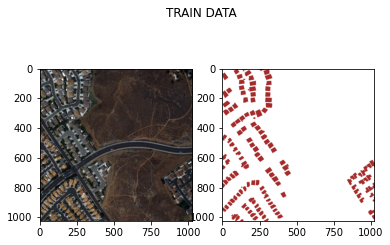

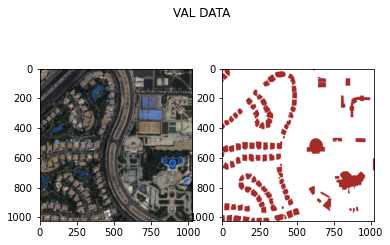

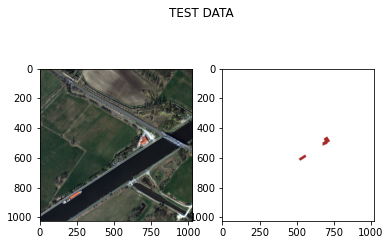

In [4]:
import matplotlib.pyplot as plt
i = 0

with h5py.File(FILE_PATH, 'r') as hdf5_file:
    plt.suptitle('TRAIN DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file['B']['train']['img'][i])
    plt.subplot(122)
    plt.imshow(hdf5_file['B']['train']['label'][i])
    plt.show()
    
    plt.suptitle('VAL DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file['B']['val']['img'][i])
    plt.subplot(122)
    plt.imshow(hdf5_file['B']['val']['label'][i])
    plt.show()
    
    plt.suptitle('TEST DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file['B']['test']['img'][i])
    plt.subplot(122)
    plt.imshow(hdf5_file['B']['test']['label'][i])
    plt.show()

## Split and Save image
---

### 함수정의

In [8]:
def get_slice_pos(split_cnt, STRIDE_SIZE, INPUT_SIZE):
    pts = []
    for slice_pos in range(split_cnt):
        pos_i = int(math.floor(slice_pos / 5.0))
        pos_j = int(slice_pos % 5)
        x = STRIDE_SIZE * pos_i
        y = STRIDE_SIZE * pos_j
        pts.append((x, x+INPUT_SIZE, y, y+INPUT_SIZE))
    return pts

In [9]:
def split_png(img, pts):
    if len(img.shape) == 3:
        sub_imgs = [img[x0:x1, y0:y1, :] for x0, x1, y0, y1 in pts]
    elif len(img.shape) == 2:
        sub_imgs = [img[x0:x1, y0:y1] for x0, x1, y0, y1 in pts]
    return sub_imgs

In [10]:
def save_png_imgs_labels(dataset, i, imgs, labels):
    for img, label in zip(imgs, labels):
        dataset['img'][i, ...] = img
        dataset['label'][i, ...] = label
        i += 1
    return i

### Split

In [11]:
STRIDE_SIZE = 192
INPUT_SIZE = 256
SPLIT_CNT = 25
pts = get_slice_pos(SPLIT_CNT, STRIDE_SIZE, INPUT_SIZE)

In [35]:
with h5py.File(FILE_PATH, "a") as f:
    train_size = f[TRAIN_IMG_PATH].shape[0] * 25
    del f[TRAIN_SPLIT_DIR]
    f[BASE_TARIN_DIR].create_group('split')
    f[BASE_TARIN_DIR]['split'].create_dataset('img', (train_size, 256, 256, 3), np.uint8)
    f[BASE_TARIN_DIR]['split'].create_dataset('label', (train_size, 256, 256), np.float)

    val_size = f[VAL_IMG_PATH].shape[0] * 25
    del f[VAL_SPLIT_DIR]
    f[BASE_VAL_DIR].create_group('split')
    f[BASE_VAL_DIR]['split'].create_dataset('img', (val_size, 256, 256, 3), np.uint8)
    f[BASE_VAL_DIR]['split'].create_dataset('label', (val_size, 256, 256), np.float)

    sub_idx = 0
    for i in tqdm(range(f[TRAIN_IMG_PATH].shape[0])):
        sub_imgs = split_png(f[TRAIN_IMG_PATH][i], pts)

        mask = (f[TRAIN_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype('float')
        sub_labels = split_png(mask, pts)
        
        sub_idx = save_png_imgs_labels(f[TRAIN_SPLIT_DIR], sub_idx, sub_imgs, sub_labels)

    sub_idx = 0
    for i in tqdm(range(f[VAL_IMG_PATH].shape[0])):
        sub_imgs = split_png(f[VAL_IMG_PATH][i], pts)

        mask = (f[VAL_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype('float')
        sub_labels = split_png(mask, pts)

        sub_idx = save_png_imgs_labels(f[VAL_SPLIT_DIR], sub_idx, sub_imgs, sub_labels)

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
100%|██████████| 159/159 [00:11<00:00, 1

### Sample

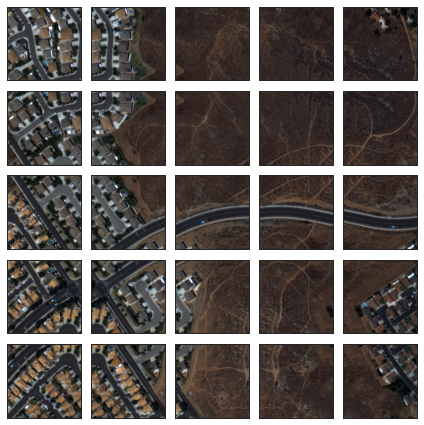

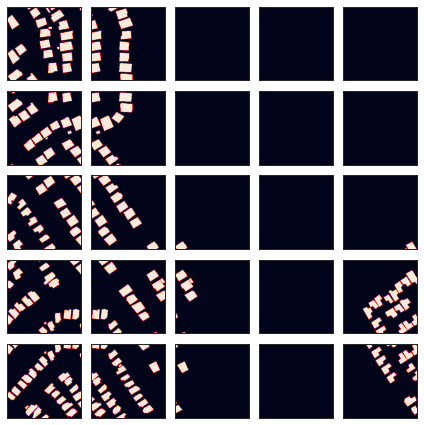

In [44]:
with h5py.File(FILE_PATH, "a") as f:
    idx = 0
    imgs = f[TRAIN_SPLIT_IMG_PATH][idx*25:idx*25+25]
    plt.figure(figsize=(6, 6))
    for i, sub_img in enumerate(imgs):
        plt.subplot(5, 5, i+1)
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.imshow(sub_img)
            
    plt.tight_layout()
    plt.show()
    
    masks = f[TRAIN_SPLIT_LABEL_PATH][idx*25:idx*25+25]
    plt.figure(figsize=(6, 6))
    for i, sub_img in enumerate(masks):
        plt.subplot(5, 5, i+1)
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.imshow(sub_img)
            
    plt.tight_layout()
    plt.show()

## Dataloader and utility functions
---

In [13]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(10, 5))
    
    for i, (name, image) in enumerate(images.items()):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(' '.join(name.split('_')).title())
        axs[i].imshow(image)
        
    plt.tight_layout()
    plt.show()

In [14]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [15]:
# classes for data loading and preprocessing
class Dataset:
    def __init__(
        self, 
        filepath,
        x_path,
        y_path,
        augmentation=None, 
        preprocessing=None,
    ):
        self.filepath = filepath
        self.x_path = x_path
        self.y_path = y_path
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.size = 0
        with h5py.File(self.filepath, 'r') as f:
            self.size = f[x_path].shape[0]
    
    def __getitem__(self, i):
        with h5py.File(self.filepath, 'r') as f:
            if isinstance(i, slice):
                start, stop, step = i.indices(self.size)
                images = f[self.x_path][start:stop]
                masks = f[self.y_path][start:stop]
                res = [(img, mask) for img, mask in zip(images, masks)]

                if self.augmentation:
                    res = [self.augmentation(image=img, mask=mask) for img, mask in res]
                    res = [(r['image'], r['mask']) for r in res]
                if self.preprocessing:
                    res = [self.augmentation(image=img, mask=mask) for img, mask in res]
                    res = [(r['image'], r['mask']) for r in res]
                images = np.array([img for img, _ in res ])
                masks = np.array([mask for _, mask in res ])

                return (images, masks)
            else:
                image = f[self.x_path][i]
                mask = f[self.y_path][i]

                # apply augmentations
                if self.augmentation:
                    sample = self.augmentation(image=image, mask=mask)
                    image, mask = sample['image'], sample['mask']
                
                # apply preprocessing
                if self.preprocessing:
                    sample = self.preprocessing(image=image, mask=mask)
                    image, mask = sample['image'], sample['mask']

                return image, mask
        
    def __len__(self):
        return self.size

In [16]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = self.dataset[start : stop]
        return data
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [17]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        A.CLAHE(clip_limit=4.0, tile_grid_size=(16, 16), p=1),
        A.RandomRotate90(p=0.75),
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.25),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

- test

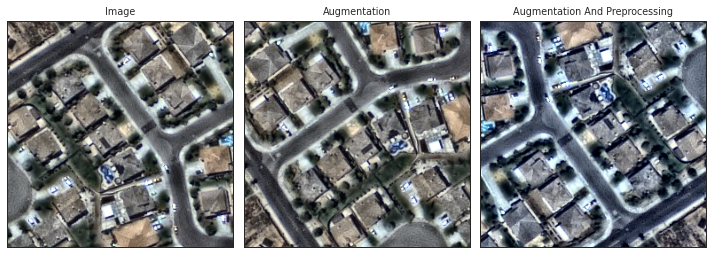

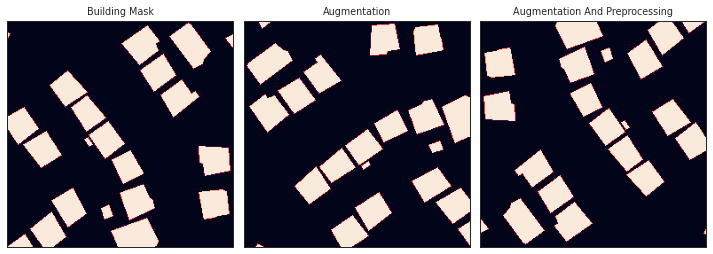

In [47]:
# Lets look at augmented data we have
dataset = Dataset(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation()
)

dataset_aug = Dataset(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation())

preprocess_input = sm.get_preprocessing('efficientnetb3')
dataset_aug_pre = Dataset(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)


image, mask = dataset[5] # get some sample
image_aug, mask_aug = dataset_aug[5]
image_aug_pre, mask_aug_pre = dataset_aug_pre[5]


visualize(
    image=image, 
    augmentation=image_aug,
    augmentation_and_preprocessing=denormalize(image_aug_pre)
)

visualize(
    building_mask=mask,
    augmentation=mask_aug,
    augmentation_and_preprocessing=mask_aug_pre
)

## Model training
---

### 모델 정의

In [23]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['building']
EPOCHS = 10

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [24]:
# define optomizer
momentum = 0.9
initial_learning_rate = 0.01
t_period = 10000
lr_min = 0.000001
lr_scheduler = tf.keras.experimental.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=t_period,
    alpha=lr_min / initial_learning_rate)
optim = keras.optimizers.SGD(learning_rate=lr_scheduler, momentum=momentum, nesterov=True)

In [25]:
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [26]:
# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [48]:
# Dataset for train images
preprocess_input = sm.get_preprocessing('efficientnetb3')
train_dataset = Dataset(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

# Dataset for validation images
valid_dataset = Dataset(
    FILE_PATH,
    VAL_SPLIT_IMG_PATH, 
    VAL_SPLIT_LABEL_PATH, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

- inference

In [48]:
def show_spiltd_img(imgs, denor=False):
    plt.figure(figsize=(7, 7))
    for i, sub_img in enumerate(imgs):
        plt.subplot(5, 5, i+1)
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        if denor:
            plt.imshow(denormalize(sub_img))
        else:
            plt.imshow(sub_img)
    plt.tight_layout()
    plt.show()

In [49]:
def inference(img, pts):
    preprocessing = A.Compose([
        A.Lambda(image=sm.get_preprocessing(BACKBONE)),
    ])

    sub_imgs = split_png(img, pts)
    sub_imgs = [preprocessing(image=img)['image'] for img in sub_imgs]
#     show_spiltd_img(sub_imgs, denor=True)

    sub_imgs = [np.expand_dims(img, axis=0) for img in sub_imgs]
    pre_imgs = [model.predict(img) for img in sub_imgs]
    pre_imgs = [pre[..., 0].squeeze() for pre in pre_imgs]
    pre_imgs = [pre.round().clip(0, 1) for pre in pre_imgs]
#     show_spiltd_img(pre_imgs)
    
    merged = np.zeros((1024, 1024))
    for i, (x0, x1, y0, y1) in enumerate(pts) : 
        sub = (merged[x0:x1, y0:y1] + pre_imgs[i])/2
        sub = np.where(sub - sub//1 > 0, sub+0.00001, sub)
        sub = np.round(sub)
        merged[x0:x1, y0:y1] = sub
    return merged

- callbacks

In [50]:
# https://www.tensorflow.org/tutorials/images/segmentation
class SavePredictCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        with h5py.File(FILE_PATH, "r") as f:
            self.sample_img = f['B']['test']['img'][1]
            mask = (f['B']['test']['label'][1] == COLOR_MAP[0])
            self.sample_label = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype('float')
            
    def on_epoch_end(self, epoch, logs=None):
        # save prediction
        inferenced = inference(self.sample_img, pts)
        images = {'Image': self.sample_img, 
                  'Ground Truth': self.sample_label,
                  'Prediction': inferenced}
        
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        for i, (name, image) in enumerate(images.items()):
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            axs[i].set_title(' '.join(name.split('_')).title())
            axs[i].imshow(image)

        plt.tight_layout()
        plt.savefig(f'{TRAIN_RESULT_DIR}/E3_6/epoch_{epoch+1}.png')

In [52]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint(TRAIN_RESULT_DIR, save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    SavePredictCallback()
]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

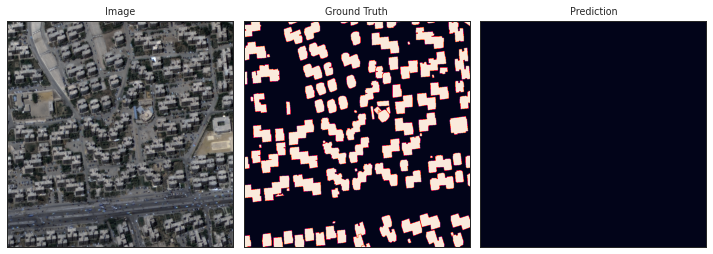

In [26]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=1, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

## Visualization of results on test dataset
---

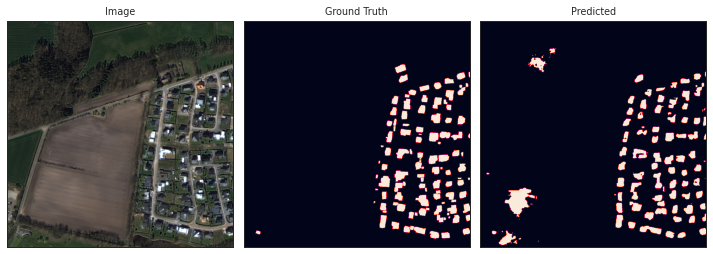

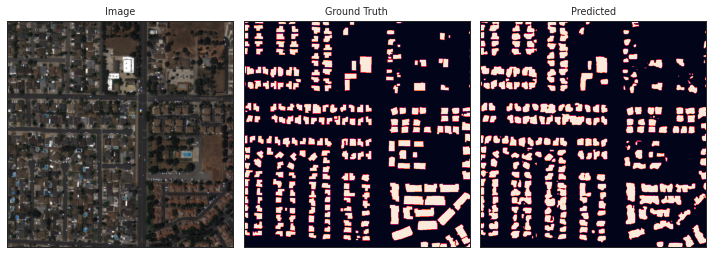

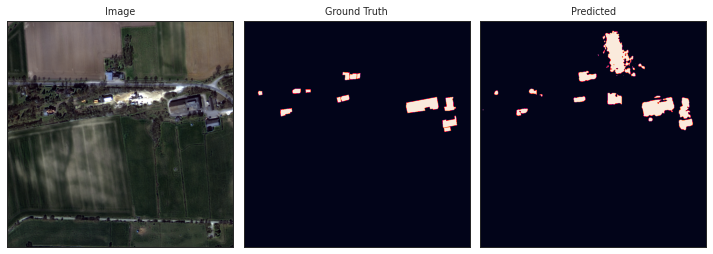

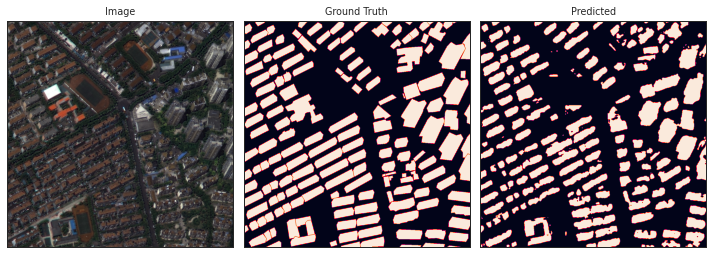

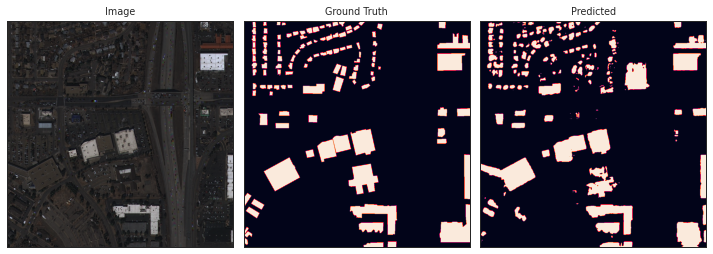

In [51]:
with h5py.File(FILE_PATH, "r") as f:
    idxs = np.random.choice(np.arange(100), size=5)

    for idx in idxs:
        img = f['B']['test']['img'][idx]
        mask = (f['B']['test']['label'][idx] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype('float')
        
        
        predicted = inference(img, pts)
        images = {'Image': img, 
                  'Ground Truth': mask,
                  'Prediction': inferenced}

        visualize(
            image=img,
            ground_truth=mask,
            predicted=predicted
        )

## additional information
---

### 1. learning rate
- ref : https://github.com/peteryuX/pcdarts-tf2/blob/4ecf2224cd414586d988c2d3d4316af0d518e8e8/modules/lr_scheduler.py
- ref : https://velog.io/@changdaeoh/learningrateschedule

In [63]:
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
mpl.style.use('default')
import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('paper')

def MultiStepLR(initial_learning_rate, lr_steps, lr_rate, name='MultiStepLR'):
    """Multi-steps learning rate scheduler."""
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=lr_steps, values=lr_steps_value)


def CosineAnnealingLR_Restart(initial_learning_rate, t_period, lr_min=0.):
    """Cosine annealing learning rate scheduler with restart."""
    return tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate=initial_learning_rate,
        first_decay_steps=t_period, t_mul=1.0, m_mul=1.0,
        alpha=lr_min / initial_learning_rate)


def CosineAnnealingLR(initial_learning_rate, t_period, lr_min=0.):
    """Cosine annealing learning rate scheduler with restart."""
    return tf.keras.experimental.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=t_period, alpha=lr_min / initial_learning_rate)


def show_learning_rate(lr_scheduler, title="Title"):
    N_iter = 10000
    step_list = list(range(0, N_iter, 10))
    lr_list = []
    for i in step_list:
        current_lr = lr_scheduler(i).numpy()
        lr_list.append(current_lr)

    plt.figure(1)
    plt.subplot(111)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    plt.title(title, fontsize=16, color='k')
    plt.plot(step_list, lr_list, linewidth=1.5, label='learning rate scheme')
    legend = plt.legend(loc='upper right', shadow=False)
    ax = plt.gca()
    labels = ax.get_xticks().tolist()
    for k, v in enumerate(labels):
        labels[k] = str(int(v / 1000)) + 'K'
    ax.set_xticklabels(labels)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

    ax.set_ylabel('Learning rate')
    ax.set_xlabel('Iteration')
    fig = plt.gcf()
    plt.show()

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


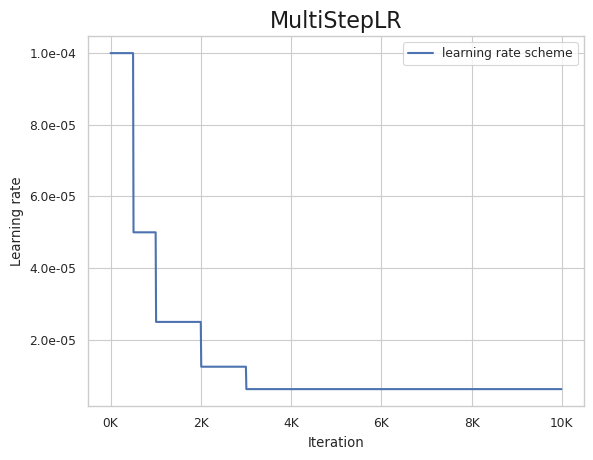

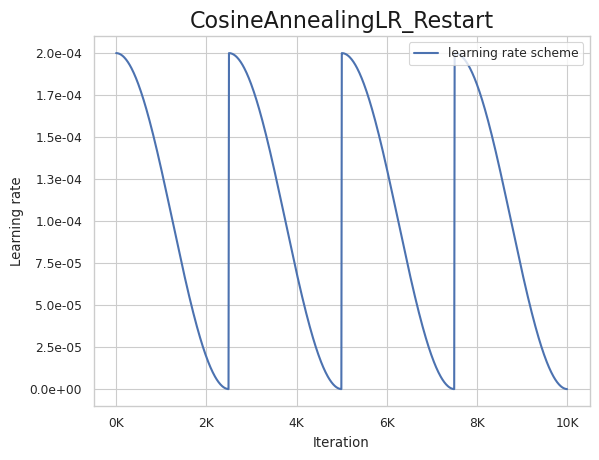

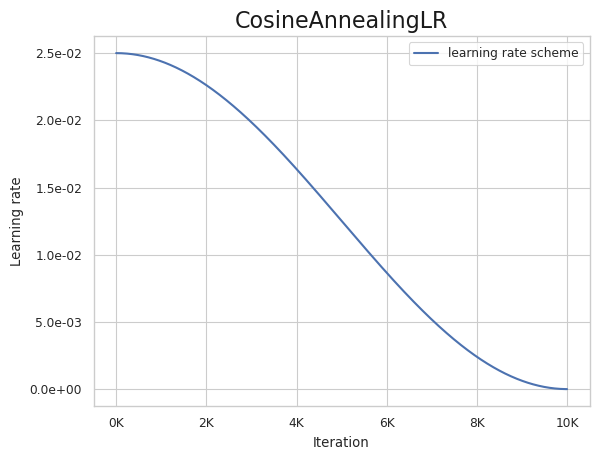

In [64]:
show_learning_rate(MultiStepLR(1e-4, [500, 1000, 2000, 3000], 0.5), 'MultiStepLR')
show_learning_rate(CosineAnnealingLR_Restart(2e-4, 2500, 1e-7), 'CosineAnnealingLR_Restart')
show_learning_rate(CosineAnnealingLR(0.025, 10000, 0), 'CosineAnnealingLR')